In [58]:
import os
import sys
sys.path.append('../src')
os.getcwd()

%pip install -e .. -qqq

Note: you may need to restart the kernel to use updated packages.


In [59]:
import numpy as np
import pandas as pd
import tensorflow as tf
import zlib
import shutil
import importlib
from pathlib import Path
from datetime import datetime

from ecgxai.utils import save_run, load_run
from ecgxai.config_targets import TARGET_META
from ecgxai.explainer import run_fused_pipeline_for_classes
from ecgxai.selection import build_selection_df_with_aliases
from ecgxai.stability_eval import run_extra_beat_stability_experiment
from ecgxai.eval import evaluate_all_payloads
from ecgxai.config import get_settings

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
ROOT = Path.cwd().parent
SAMPLE_ROOT = ROOT / "data" / "sample"

os.environ["ECGXAI_DATA_ROOT"] = str(SAMPLE_ROOT)

import ecgxai.config
importlib.reload(ecgxai.config)

print(ecgxai.config.DATA_ROOT)
print(ecgxai.config.get_settings())

MODEL_PATH         = ROOT / "model" / "resnet_final.h5"
ECG_FILENAMES_PATH = ROOT / "data" / "ecg_filenames.npy"
PROBS_PATH         = ROOT / "data" / "ecg_model_probs.npy"
CLASS_NAMES_PATH   = ROOT / "data" / "snomed_classes.npy"
Y_TRUE_PATH        = ROOT / "data" / "ecg_y_true.npy"
ECG_DURATIONS_PATH = ROOT / "data" / "ecg_durations.npy"
STAB_OUT_DIR       = ROOT / "outputs" / "extra_beat_aug"
ECG_PRED_PATH      = ROOT / "outputs" / "ecg_xai_sel_meta_p0.85_k5.csv"

model = tf.keras.models.load_model(MODEL_PATH, compile=False)
class_names = np.load(CLASS_NAMES_PATH, allow_pickle=True)

c:\UHull\ecg-xai\data\sample
Settings(maxlen=5000, random_seed=42, data_root=WindowsPath('c:/UHull/ecg-xai/data/sample'))


In [61]:
from ecgxai.config import DATA_ROOT, MAXLEN
from ecgxai.utils import import_key_data
from ecgxai.ecg_predict import batched_predict_all
from ecgxai.selection import build_y_true_from_labels

gender, age, labels, ecg_filenames = import_key_data(DATA_ROOT)

# 1) Build ground-truth multi-hot labels
y_true = build_y_true_from_labels(labels, class_names)

# 2) Predict probabilities
probs = batched_predict_all(
    model,
    ecg_filenames,
    maxlen=MAXLEN,
    batch_size=32,
)

# 3) Optional: binary predictions (0/1) at some threshold
pred_threshold = 0.5
y_pred = (probs >= pred_threshold).astype(np.int8)

Y_PRED_PATH      = ROOT / "outputs" / f"ecg_y_pred_{pred_threshold:.2f}.npy"

# 4) Save everything
np.save(ECG_FILENAMES_PATH, ecg_filenames)
np.save(PROBS_PATH, probs)
np.save(Y_TRUE_PATH, y_true)
np.save(Y_PRED_PATH, y_pred)


Predicting ECGs: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]


In [62]:
ecg_filenames = np.load(ECG_FILENAMES_PATH, allow_pickle=True)
probs         = np.load(PROBS_PATH)
class_names   = np.load(CLASS_NAMES_PATH, allow_pickle=True)
y_true        = np.load(Y_TRUE_PATH)

sel_df = build_selection_df_with_aliases(
    ecg_filenames=ecg_filenames,
    probs=probs,
    class_names=class_names,
    target_meta=TARGET_META,
    y_true=y_true,
    k_per_class=50,
    min_prob=0.85,
    max_duration_sec=20.0,
    duration_cache_path=str(ECG_DURATIONS_PATH)
)

sel_df.to_csv(ECG_PRED_PATH, index=False)
sel_df

[INFO] Duration filter enabled: keeping ECGs <= 20.0 s
[INFO] Duration filter: keeping 100/100 ECGs.
[CLASS 164889003 (atrial fibrillation)] picked 50 examples.
[CLASS 426783006 (sinus rhythm)] picked 50 examples.


,group_class,filename,sel_idx,duration_sec,prob_meta
0,164889003,c:\UHull\ecg-xai\data\sample\A2978.mat,19,10.00,0.986492
1,164889003,c:\UHull\ecg-xai\data\sample\A2643.mat,16,14.00,0.998341
2,164889003,c:\UHull\ecg-xai\data\sample\A0003.mat,0,10.00,0.959976
3,164889003,c:\UHull\ecg-xai\data\sample\A4502.mat,27,17.97,0.990211
4,164889003,c:\UHull\ecg-xai\data\sample\HR03231.mat,82,10.00,0.923075
...,...,...,...,...,...
95,426783006,c:\UHull\ecg-xai\data\sample\HR00938.mat,55,10.00,0.897381
96,426783006,c:\UHull\ecg-xai\data\sample\HR04232.mat,95,10.00,0.969635
97,426783006,c:\UHull\ecg-xai\data\sample\HR00005.mat,43,10.00,0.993680
98,426783006,c:\UHull\ecg-xai\data\sample\HR03323.mat,86,10.00,0.934140


In [63]:
# ---- choose mode ----
run_mode = "demo"   # "eval" or "demo"

MODE_CFG = {
    "eval": {"max_examples_per_class": 50, "plot": False},
    "demo": {"max_examples_per_class": 3,  "plot": True},
}

EVAL_CSV_PATH      = ROOT / "outputs" / run_mode / 'df_eval_attauc_deletion.csv'
STAB_CSV_PATH      = ROOT / "outputs" / run_mode / "df_eval_stability.csv"

In [64]:
cfg = MODE_CFG[run_mode]

OUT_BASE = ROOT / "outputs"
RUN_DIR = OUT_BASE / run_mode

# ---- cache check ----
def run_assets_exist(run_dir: Path) -> bool:
    return (
        (run_dir / "all_fused_payloads.joblib").exists()
        and (run_dir / "df_lime_all.parquet").exists()
        and (run_dir / "df_ts_all.parquet").exists()
        and (run_dir / "sel_df.parquet").exists()
    )

target_classes = list(TARGET_META.keys())

if run_assets_exist(RUN_DIR):
    print(f"[{run_mode}] Loading cached assets from: {RUN_DIR}")
    all_fused_payloads, df_lime_all, df_ts_all, sel_df_cached = load_run(RUN_DIR)
    
    # Optionally replace sel_df with cached one to keep indices consistent
    sel_df = sel_df_cached
else:
    print(f"[{run_mode}] No cache found. Running pipeline...\n")
    all_fused_payloads, df_lime_all, df_ts_all = run_fused_pipeline_for_classes(
        target_classes=target_classes,
        sel_df=sel_df,
        model=model,
        class_names=class_names,
        max_examples_per_class=cfg["max_examples_per_class"],
        plot=cfg["plot"],
    )

    save_run(
        RUN_DIR,
        all_fused_payloads,
        df_lime_all,
        df_ts_all,
        sel_df,
        meta={
            "mode": run_mode,
            "saved_at": datetime.now().isoformat(timespec="seconds"),
            "target_classes": target_classes,
            "max_examples_per_class": cfg["max_examples_per_class"],
            "plot": cfg["plot"],
        },
    )
    print(f"[{run_mode}] Saved to: {RUN_DIR}")

# after sel_df is ready
sel_df = sel_df.groupby("group_class", as_index=False, sort=False).head(cfg["max_examples_per_class"])

[demo] Loading cached assets from: c:\UHull\ecg-xai\outputs\demo


In [67]:
import time
import numpy as np
import pandas as pd

from ecgxai.plot import plot_from_payload
from ecgxai.explainer import default_explainer_config
from ecgxai.payload import payload_from_lime_row, payload_from_timeshap_row
from ecgxai.fusion import fuse_lime_timeshap_payload
from ecgxai.ecg_lime import run_lime_for_one_class_from_sel
from ecgxai.ecg_timeshap import run_timeshap_for_one_class_from_sel
from ecgxai.eval import evaluate_all_payloads


def _safe_class_idx(class_names, cls_code: str):
    cls_arr = np.array(class_names).astype(str)
    hits = np.where(cls_arr == str(cls_code))[0]
    return int(hits[0]) if len(hits) else None

def _pick_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def _is_span_dict(d):
    if not isinstance(d, dict):
        return False
    ks = set(d.keys())
    return (
        {"start","end"}.issubset(ks) or
        {"t0","t1"}.issubset(ks) or
        {"i0","i1"}.issubset(ks) or
        {"start_idx","end_idx"}.issubset(ks)
    )

def _extract_top_spans(payload, max_items=5):
    # recursive best-effort: finds any list of span-like dicts inside payload
    stack = [payload]
    while stack:
        obj = stack.pop()
        if isinstance(obj, list) and obj:
            sample = obj[: min(3, len(obj))]
            if all(_is_span_dict(x) for x in sample):
                return obj[:max_items]
            for x in obj:
                if isinstance(x, (dict, list)):
                    stack.append(x)
        elif isinstance(obj, dict):
            for v in obj.values():
                if isinstance(v, (dict, list)):
                    stack.append(v)
    return []


def run_demo_for_class(
    class_code,
    pick="maxprob",          # "maxprob" or "first"
    val_idx_override=None,   # set to an int if you want a specific record
    topk=5
):
    # --- ensure val_idx exists ---
    IDX_COL = _pick_col(sel_df, ["val_idx", "sel_idx", "ecg_idx", "record_idx", "idx"])
    df = sel_df.copy()
    if "val_idx" not in df.columns:
        if IDX_COL is not None:
            df["val_idx"] = df[IDX_COL].astype(int)
        else:
            df["val_idx"] = df.index.astype(int)

    CLS_COL = _pick_col(df, ["group_class", "meta_code", "class_code", "snomed_code", "label_code"])

    cls_str = str(class_code)
    cls_idx = _safe_class_idx(class_names, cls_str)

    # --- filter to class if possible ---
    df_cls = df
    if CLS_COL is not None:
        df_cls = df[df[CLS_COL].astype(str) == cls_str]
        if df_cls.empty:
            df_cls = df  # fallback

    # --- choose record ---
    if val_idx_override is not None:
        demo_val_idx = int(val_idx_override)
        demo_prob = float(probs[demo_val_idx, cls_idx]) if cls_idx is not None else float("nan")
    else:
        if pick == "maxprob" and cls_idx is not None:
            tmp = df_cls.copy()
            tmp["_idx"] = tmp["val_idx"].astype(int)
            tmp["_prob"] = tmp["_idx"].map(
                lambda i: float(probs[i, cls_idx]) if 0 <= i < probs.shape[0] else np.nan
            )
            tmp = tmp.dropna(subset=["_prob"]).sort_values("_prob", ascending=False)
            demo_val_idx = int(tmp.iloc[0]["_idx"]) if len(tmp) else int(df_cls.iloc[0]["val_idx"])
            demo_prob = float(tmp.iloc[0]["_prob"]) if len(tmp) else float("nan")
        else:
            demo_val_idx = int(df_cls.iloc[0]["val_idx"])
            demo_prob = float(probs[demo_val_idx, cls_idx]) if cls_idx is not None else float("nan")

    print(f"Demo pick → class={cls_str} | val_idx={demo_val_idx} | prob={demo_prob:.4f}")

    sel_one = df[df["val_idx"].astype(int).eq(demo_val_idx)].copy()

    # --- explain ---
    one_class_config = default_explainer_config(class_code)

    t0 = time.perf_counter()
    df_l = run_lime_for_one_class_from_sel(
        sel_df=sel_one,
        class_name=class_code,
        model=model,
        class_names=class_names,
        window_sec=one_class_config["window_sec"],
        m_event=one_class_config["m_event"],
        m_feat=one_class_config["m_feat"],
        topk_events=one_class_config["topk_events"],
        explain_class="force",
        mode=one_class_config["mode"],
        rng=42,
        params=one_class_config.get("params"),
    )
    t_lime = time.perf_counter() - t0

    t0 = time.perf_counter()
    df_t = run_timeshap_for_one_class_from_sel(
        sel_df=sel_one,
        class_name=class_code,
        model=model,
        class_names=class_names,
        window_sec=one_class_config["window_sec"],
        m_event=one_class_config["m_event"],
        m_feat=one_class_config["m_feat"],
        topk_events=one_class_config["topk_events"],
        explain_class="force",
        mode=one_class_config["mode"],
        rng=42,
        link="logit",
        params=one_class_config.get("params"),
    )
    t_ts = time.perf_counter() - t0

    print(f"Computed demo explanation (1 record): LIME={t_lime:0.1f}s | TimeSHAP={t_ts:0.1f}s")

    # --- fuse + plot ---
    payload_L = payload_from_lime_row(df_l.iloc[0], label_for_title=cls_str)
    payload_T = payload_from_timeshap_row(df_t.iloc[0], label_for_title=cls_str)

    payload_F = fuse_lime_timeshap_payload(
        payload_L=payload_L,
        payload_T=payload_T,
        agg="geomean",
        beta=0.35,
        tau=0.02,
        tau_mode="abs",
        topk=topk,
        method_weights=(0.5, 0.5),
        sign_policy="penalize",
        gap_merge=0.02,
        wt_merge_tol=0.15,
        force_leads=(),
    )

    plot_from_payload(payload_F)

    # --- metrics row ---
    one_payloads = {cls_str: {int(demo_val_idx): payload_F}}
    df_one = evaluate_all_payloads(
        all_payloads=one_payloads,
        method_label="LIME+TimeSHAP (single)",
        model=model,
        class_names=class_names,
    )

    row = df_one.iloc[0].to_dict()
    row.update({
        "class_code": cls_str,
        "class_name": TARGET_META.get(class_code, TARGET_META.get(cls_str, {})).get("name", "UNKNOWN"),
        "val_idx": demo_val_idx,
        "model_prob": demo_prob,
        "top_spans": _extract_top_spans(payload_F, max_items=5),
    })

    cols = [
        "class_code","class_name","val_idx","model_prob","top_spans",
        *[c for c in ["strict_attauc","lenient_attauc","strict_p_at_k","lenient_p_at_k","deletion_auc","faithfulness_gain"] if c in row]
    ]
    return pd.DataFrame([row])[cols]


Demo pick → class=164889003 | val_idx=16 | prob=0.9983
Computed demo explanation (1 record): LIME=15.9s | TimeSHAP=16.4s


<Figure size 2000x600 with 0 Axes>

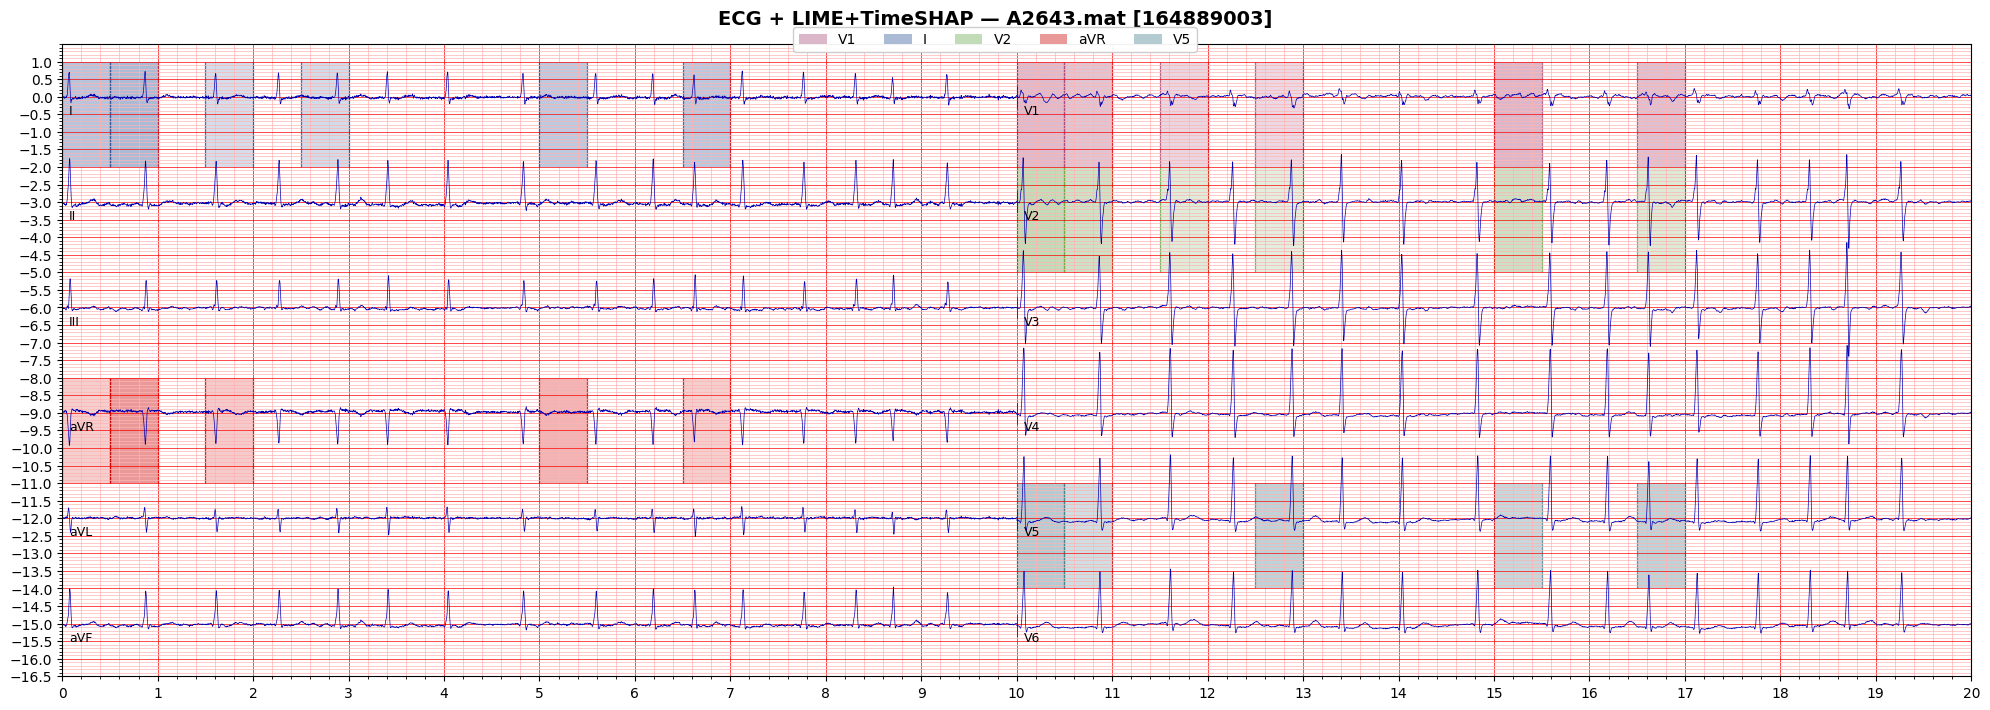

,class_code,class_name,val_idx,model_prob,top_spans,strict_attauc,lenient_attauc,strict_p_at_k,lenient_p_at_k,deletion_auc,faithfulness_gain
0,164889003,atrial fibrillation,16,0.998341,[],0.861806,0.710286,0.5,1.0,0.286125,0.055634


Demo pick → class=426783006 | val_idx=79 | prob=0.9841
Computed demo explanation (1 record): LIME=16.8s | TimeSHAP=14.3s


<Figure size 2000x600 with 0 Axes>

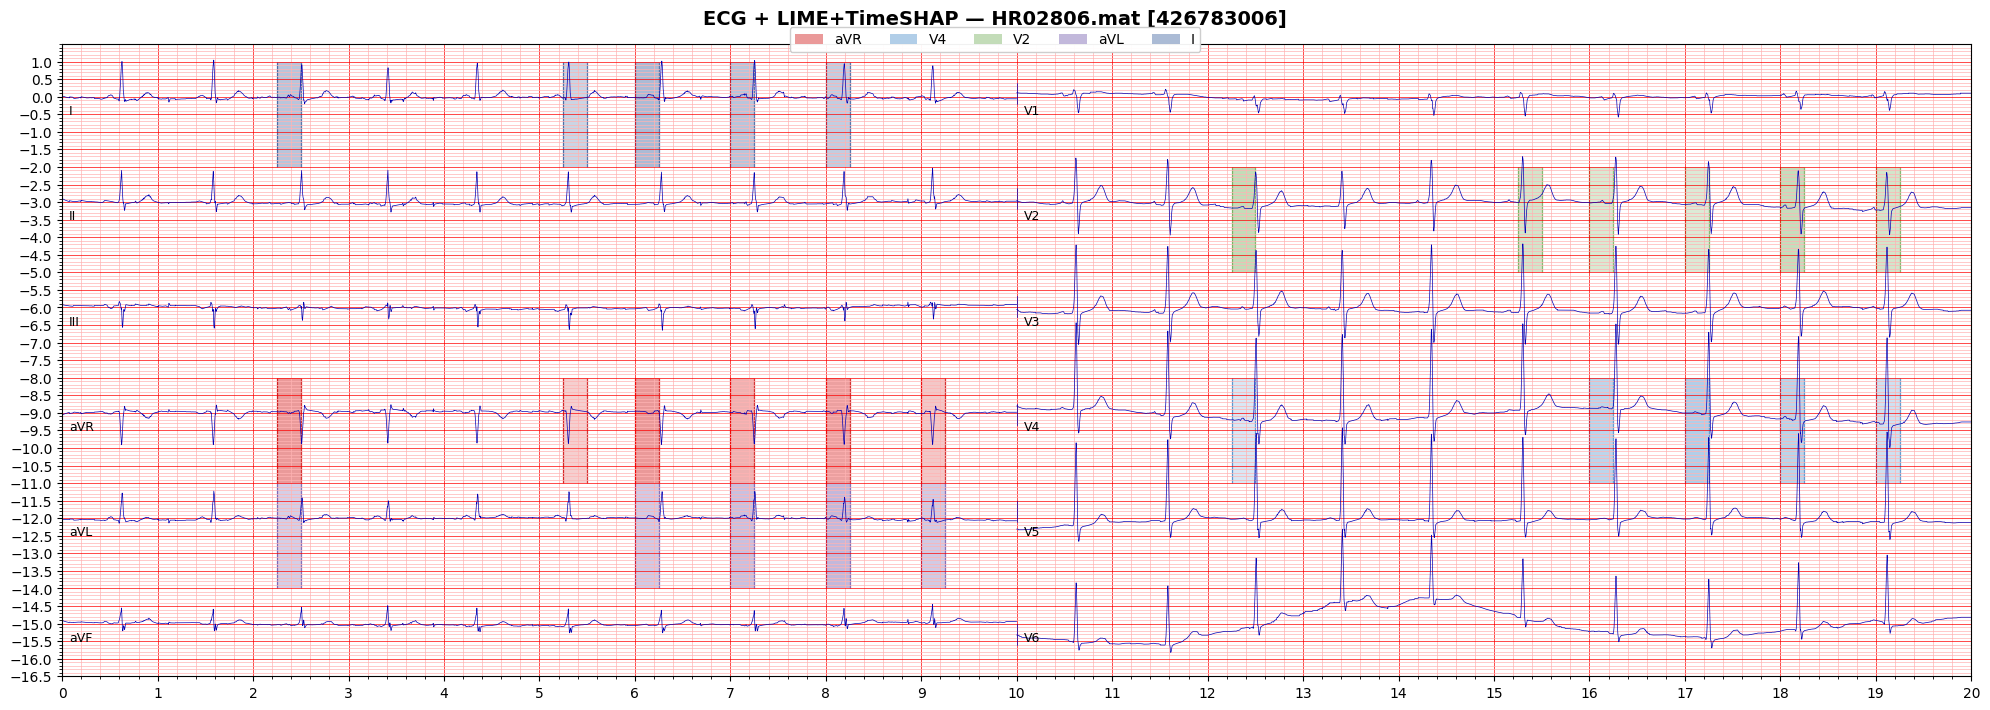

,class_code,class_name,val_idx,model_prob,top_spans,strict_attauc,lenient_attauc,strict_p_at_k,lenient_p_at_k,deletion_auc,faithfulness_gain
0,426783006,sinus rhythm,79,0.984141,[],0.805,1.0,0.3,1.0,0.29042,0.009033


In [68]:
# "164889003": Atrial fibrillation (AF)
# "426783006": Sinus rhythm (SNR)

for c in ["164889003", "426783006"]:
    display(run_demo_for_class(c))

## 6) Run LIME and TimeSHAP Explanations

In [69]:
from pathlib import Path
import joblib

OUTPUTS_BASE_PATH      = ROOT / "outputs" / run_mode

LIME_DF_PATH = OUTPUTS_BASE_PATH / "df_lime_all.pkl"
TS_DF_PATH   = OUTPUTS_BASE_PATH / "df_ts_all.pkl"
FUSED_PATH   = OUTPUTS_BASE_PATH / "fused_payloads.pkl"  # dict[class_code -> dict[val_idx -> payload]]

In [70]:
sel_df

,group_class,filename,sel_idx,duration_sec,prob_meta
0,164889003,c:\UHull\ecg-xai\data\sample\A2978.mat,19,10.0,0.986492
1,164889003,c:\UHull\ecg-xai\data\sample\A2643.mat,16,14.0,0.998341
2,164889003,c:\UHull\ecg-xai\data\sample\A0003.mat,0,10.0,0.959976
50,426783006,c:\UHull\ecg-xai\data\sample\HR03482.mat,89,10.0,0.980192
51,426783006,c:\UHull\ecg-xai\data\sample\HR03494.mat,90,10.0,0.926586
52,426783006,c:\UHull\ecg-xai\data\sample\HR02806.mat,79,10.0,0.984141


### 6.1 - LIME stage

In [71]:
from ecgxai.ecg_lime import run_lime_for_one_class_from_sel
from ecgxai.explainer import default_explainer_config  # uses per-class window/priors

target_classes = list(TARGET_META.keys())

if LIME_DF_PATH.exists():
    df_lime_all = joblib.load(LIME_DF_PATH)
    print("Loaded LIME:", LIME_DF_PATH)
else:
    lime_dfs = []
    for cls in target_classes:
        lime_cfg = default_explainer_config(cls)
        df_l = run_lime_for_one_class_from_sel(
            sel_df=sel_df,
            class_name=cls,
            model=model,
            class_names=class_names,
            window_sec=lime_cfg["window_sec"],
            m_event=lime_cfg["m_event"],
            m_feat=lime_cfg["m_feat"],
            topk_events=lime_cfg["topk_events"],
            explain_class="force",
            mode=lime_cfg["mode"],
            rng=42,
            params=cfg.get("params"),
        )
        lime_dfs.append(df_l)

    df_lime_all = pd.concat(lime_dfs, ignore_index=True)
    joblib.dump(df_lime_all, LIME_DF_PATH)
    print("Saved LIME:", LIME_DF_PATH)

df_lime_all.head()


Loaded LIME: c:\UHull\ecg-xai\outputs\demo\df_lime_all.pkl


,group_class,val_idx,filename,hea_path,mat_path,fs,window_sec,target_class_explained,event_importances_json,segments_json,window_size_samples,num_segments,top_events_idx_json,top5_lead_idx_json,perlead_spans_top5_json,lead_names
0,164889003,0,c:\UHull\ecg-xai\data\sample\A0003.mat,c:\UHull\ecg-xai\data\sample\A0003.hea,c:\UHull\ecg-xai\data\sample\A0003.mat,500.0,0.50,1,"[0.1377606987953186, 0.05298207700252533, 0.08...","[[0, 250], [250, 500], [500, 750], [750, 1000]...",250,20,"[0, 15, 10, 4, 19]","[7, 11, 0, 10, 6]","{""7"": [[0.0, 0.5, 0.0181992556899786], [7.5, 8...","I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6"
1,164889003,16,c:\UHull\ecg-xai\data\sample\A2643.mat,c:\UHull\ecg-xai\data\sample\A2643.hea,c:\UHull\ecg-xai\data\sample\A2643.mat,500.0,0.50,1,"[0.07978475093841553, 0.06930287927389145, 0.0...","[[0, 250], [250, 500], [500, 750], [750, 1000]...",250,20,"[0, 10, 5, 13, 1]","[6, 10, 3, 0, 7]","{""6"": [[0.0, 0.5, 0.0015263340901583433], [5.0...","I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6"
2,164889003,19,c:\UHull\ecg-xai\data\sample\A2978.mat,c:\UHull\ecg-xai\data\sample\A2978.hea,c:\UHull\ecg-xai\data\sample\A2978.mat,500.0,0.50,1,"[0.02683555893599987, 0.08317868411540985, 0.0...","[[0, 250], [250, 500], [500, 750], [750, 1000]...",250,20,"[4, 15, 1, 18, 19]","[6, 7, 10, 3, 8]","{""6"": [[2.0, 2.5, 0.007597285322844982], [7.5,...","I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6"
3,426783006,79,c:\UHull\ecg-xai\data\sample\HR02806.mat,c:\UHull\ecg-xai\data\sample\HR02806.hea,c:\UHull\ecg-xai\data\sample\HR02806.mat,500.0,0.25,21,"[0.006898647639900446, 0.012143904343247414, -...","[[0, 125], [125, 250], [250, 375], [375, 500],...",125,40,"[9, 24, 32, 28, 21]","[7, 3, 0, 9, 11]","{""7"": [[2.25, 2.5, 0.00274253124371171], [6.0,...","I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6"
4,426783006,89,c:\UHull\ecg-xai\data\sample\HR03482.mat,c:\UHull\ecg-xai\data\sample\HR03482.hea,c:\UHull\ecg-xai\data\sample\HR03482.mat,500.0,0.25,21,"[0.029483867809176445, -0.019499629735946655, ...","[[0, 125], [125, 250], [250, 375], [375, 500],...",125,40,"[6, 38, 11, 0, 30]","[3, 0, 1, 5, 11]","{""3"": [[1.5, 1.75, 0.0014080819673836231], [9....","I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6"


### 6.2 - TimeSHAP stage

In [72]:
from ecgxai.ecg_timeshap import run_timeshap_for_one_class_from_sel
from ecgxai.explainer import default_explainer_config

if TS_DF_PATH.exists():
    df_ts_all = joblib.load(TS_DF_PATH)
    print("Loaded TimeSHAP:", TS_DF_PATH)
else:
    ts_dfs = []
    for cls in target_classes:
        ts_cfg = default_explainer_config(cls)
        df_t = run_timeshap_for_one_class_from_sel(
            sel_df=sel_df,
            class_name=cls,
            model=model,
            class_names=class_names,
            window_sec=ts_cfg["window_sec"],
            m_event=ts_cfg["m_event"],
            m_feat=ts_cfg["m_feat"],
            topk_events=ts_cfg["topk_events"],
            explain_class="force",
            mode=ts_cfg["mode"],
            rng=42,
            link="logit",
            params=ts_cfg.get("params"),
        )
        ts_dfs.append(df_t)

    df_ts_all = pd.concat(ts_dfs, ignore_index=True)
    joblib.dump(df_ts_all, TS_DF_PATH)
    print("Saved TimeSHAP:", TS_DF_PATH)

df_ts_all.head()

Loaded TimeSHAP: c:\UHull\ecg-xai\outputs\demo\df_ts_all.pkl


,group_class,val_idx,filename,hea_path,mat_path,fs,window_sec,target_class_explained,timeshap_event_values_json,segments_json,window_size_samples,num_segments,top_events_idx_json,top5_lead_idx_json,perlead_timeshap_top5_json,lead_names,link,mode
0,164889003,0,c:\UHull\ecg-xai\data\sample\A0003.mat,c:\UHull\ecg-xai\data\sample\A0003.hea,c:\UHull\ecg-xai\data\sample\A0003.mat,500.0,0.50,1,"[0.5931363105773926, 0.2409973293542862, 0.188...","[[0, 250], [250, 500], [500, 750], [750, 1000]...",250,20,"[10, 15, 0, 4, 19]","[9, 6, 1, 10, 7]","{""9"": [[5.0, 5.5, 0.12255910784006119], [7.5, ...","I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6",logit,context
1,164889003,16,c:\UHull\ecg-xai\data\sample\A2643.mat,c:\UHull\ecg-xai\data\sample\A2643.hea,c:\UHull\ecg-xai\data\sample\A2643.mat,500.0,0.50,1,"[0.9232367873191833, 0.7250503897666931, 0.477...","[[0, 250], [250, 500], [500, 750], [750, 1000]...",250,20,"[0, 1, 10, 13, 5]","[6, 7, 10, 3, 0]","{""6"": [[0.0, 0.5, 0.547764003276825], [0.5, 1....","I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6",logit,context
2,164889003,19,c:\UHull\ecg-xai\data\sample\A2978.mat,c:\UHull\ecg-xai\data\sample\A2978.hea,c:\UHull\ecg-xai\data\sample\A2978.mat,500.0,0.50,1,"[0.26727887988090515, 0.5228448510169983, 0.00...","[[0, 250], [250, 500], [500, 750], [750, 1000]...",250,20,"[4, 8, 1, 11, 15]","[6, 7, 11, 8, 9]","{""6"": [[2.0, 2.5, 0.5107077956199646], [4.0, 4...","I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6",logit,context
3,426783006,79,c:\UHull\ecg-xai\data\sample\HR02806.mat,c:\UHull\ecg-xai\data\sample\HR02806.hea,c:\UHull\ecg-xai\data\sample\HR02806.mat,500.0,0.25,21,"[0.024257371202111244, 0.18757641315460205, -0...","[[0, 125], [125, 250], [250, 375], [375, 500],...",125,40,"[9, 10, 39, 29, 1]","[3, 9, 6, 8, 11]","{""3"": [[2.25, 2.5, 0.13172152638435364], [2.5,...","I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6",logit,context
4,426783006,89,c:\UHull\ecg-xai\data\sample\HR03482.mat,c:\UHull\ecg-xai\data\sample\HR03482.hea,c:\UHull\ecg-xai\data\sample\HR03482.mat,500.0,0.25,21,"[0.2825872302055359, -0.1521240472793579, 0.25...","[[0, 125], [125, 250], [250, 375], [375, 500],...",125,40,"[6, 13, 38, 0, 26]","[6, 11, 3, 8, 0]","{""6"": [[1.5, 1.75, -0.1895262748003006], [3.25...","I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6",logit,context


### 6.3 - Run fused LIME + TimeSHAP pipeline

<Figure size 2000x600 with 0 Axes>

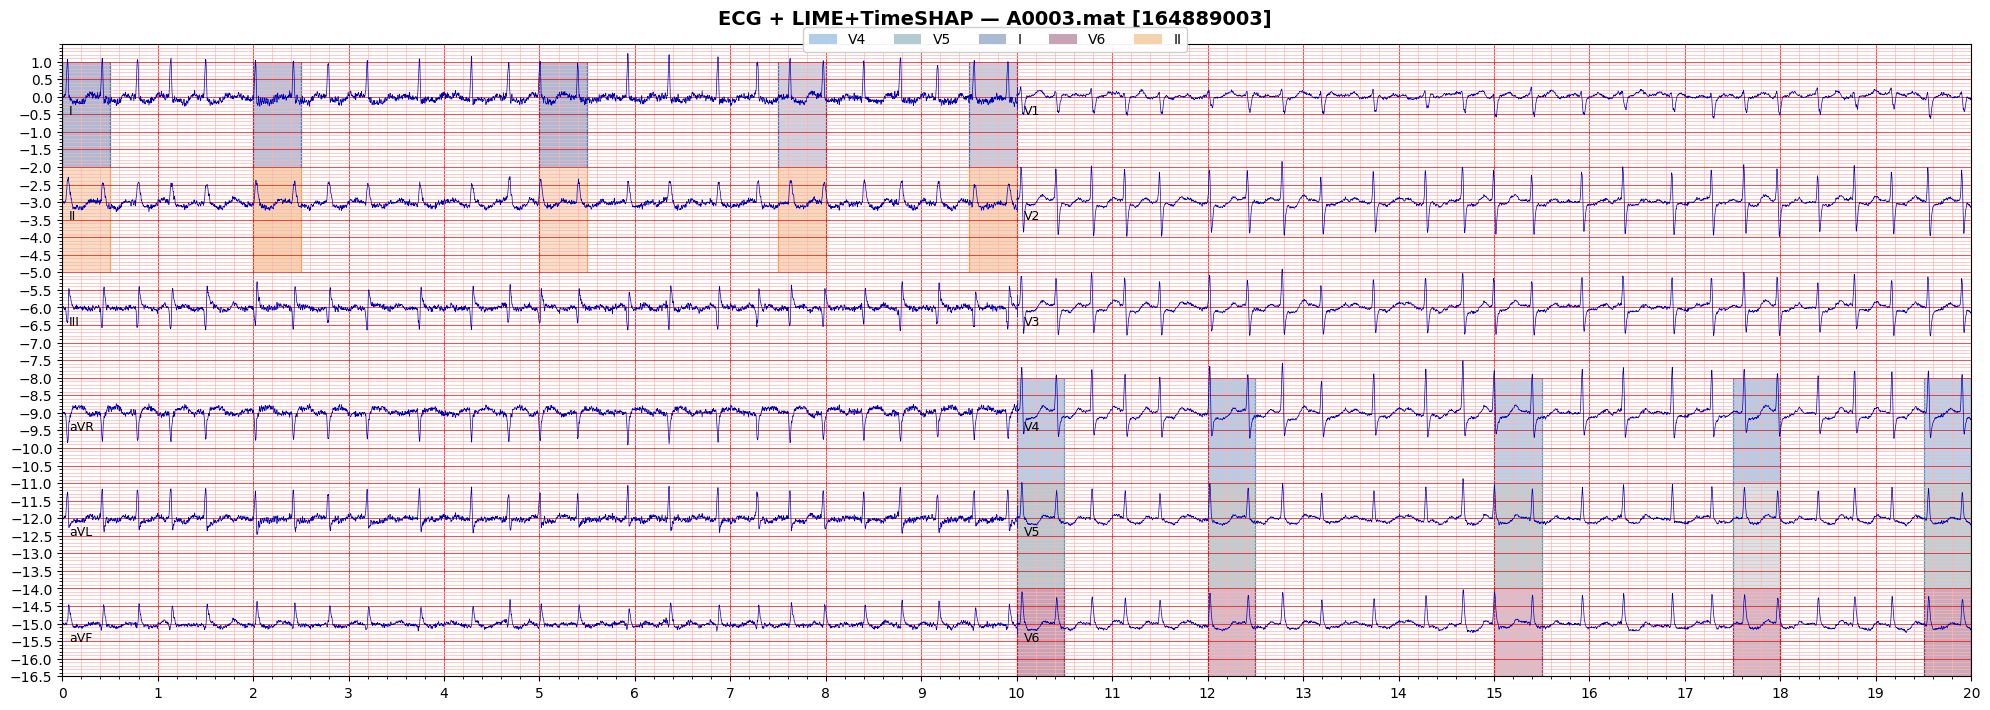

<Figure size 2000x600 with 0 Axes>

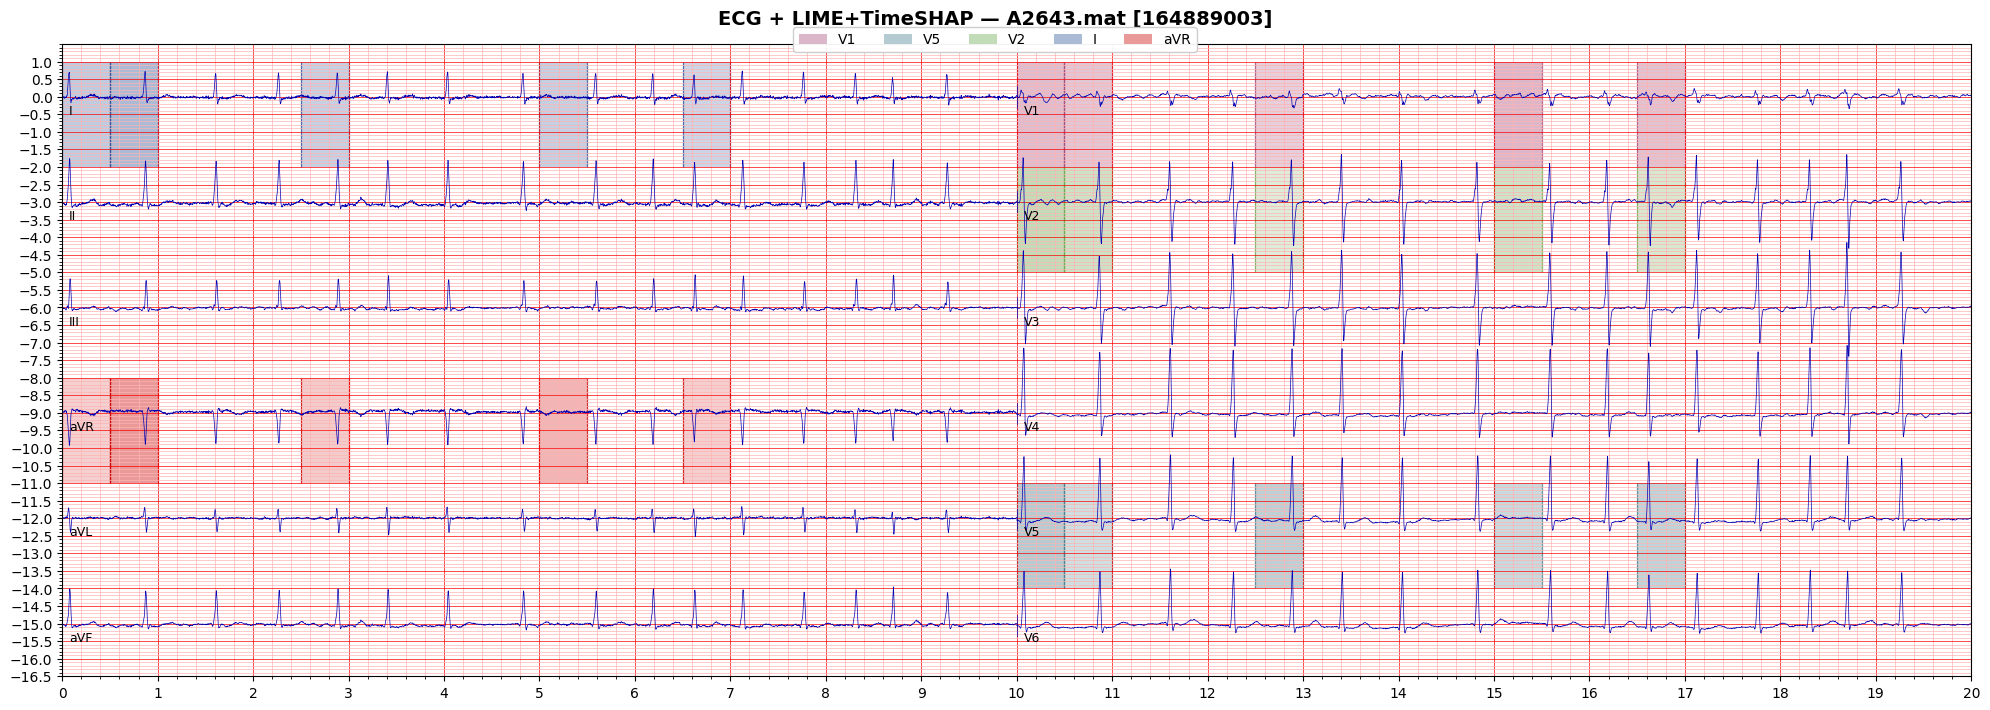

<Figure size 2000x600 with 0 Axes>

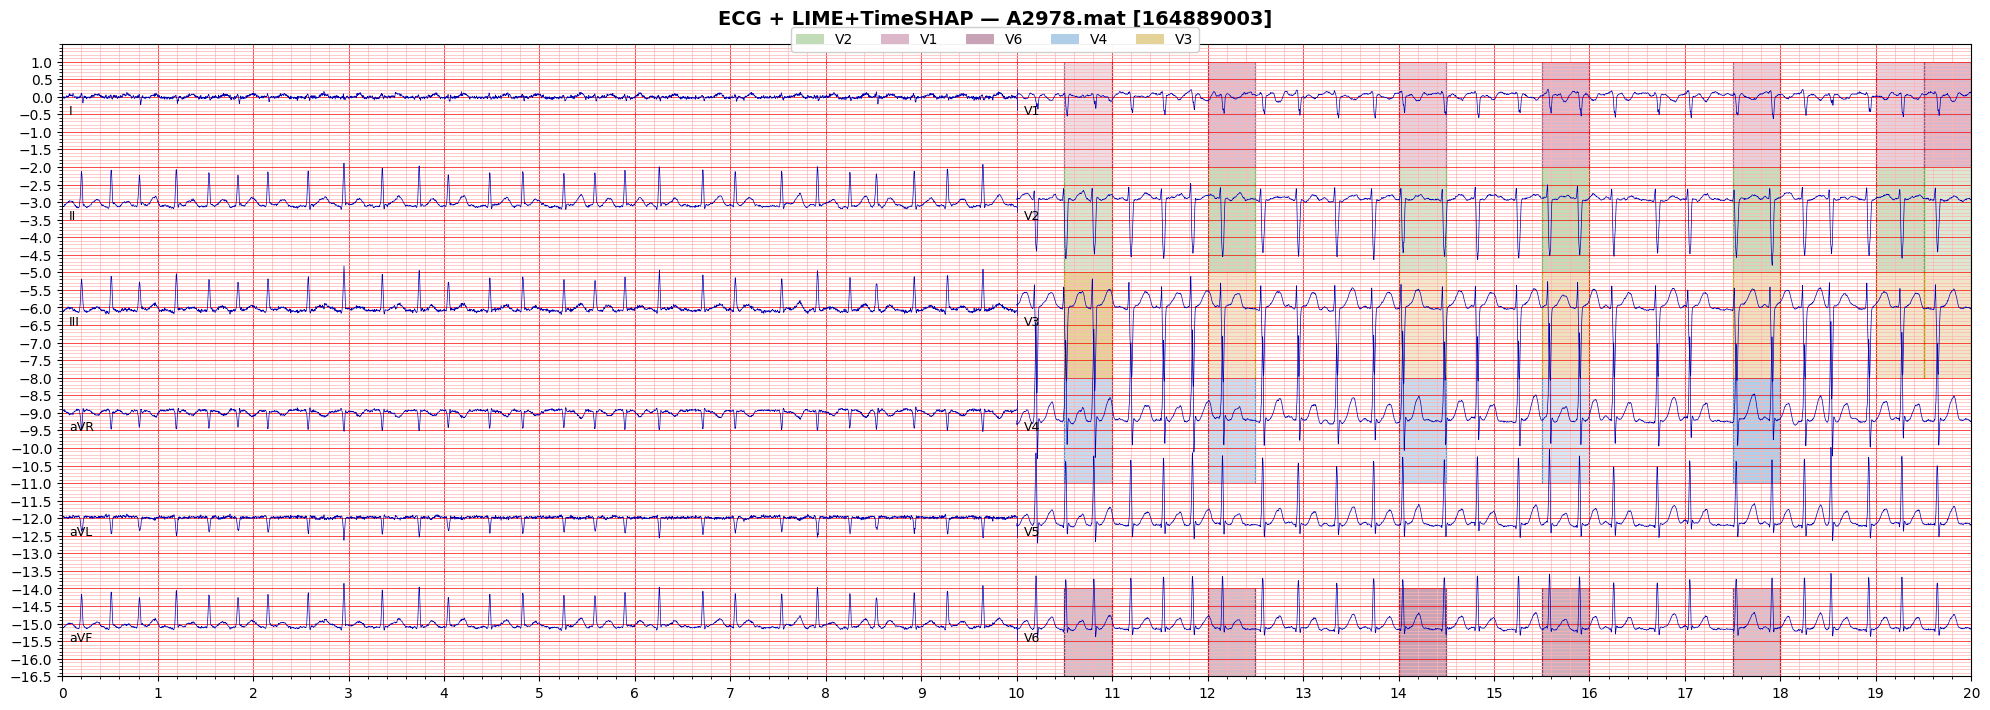

<Figure size 2000x600 with 0 Axes>

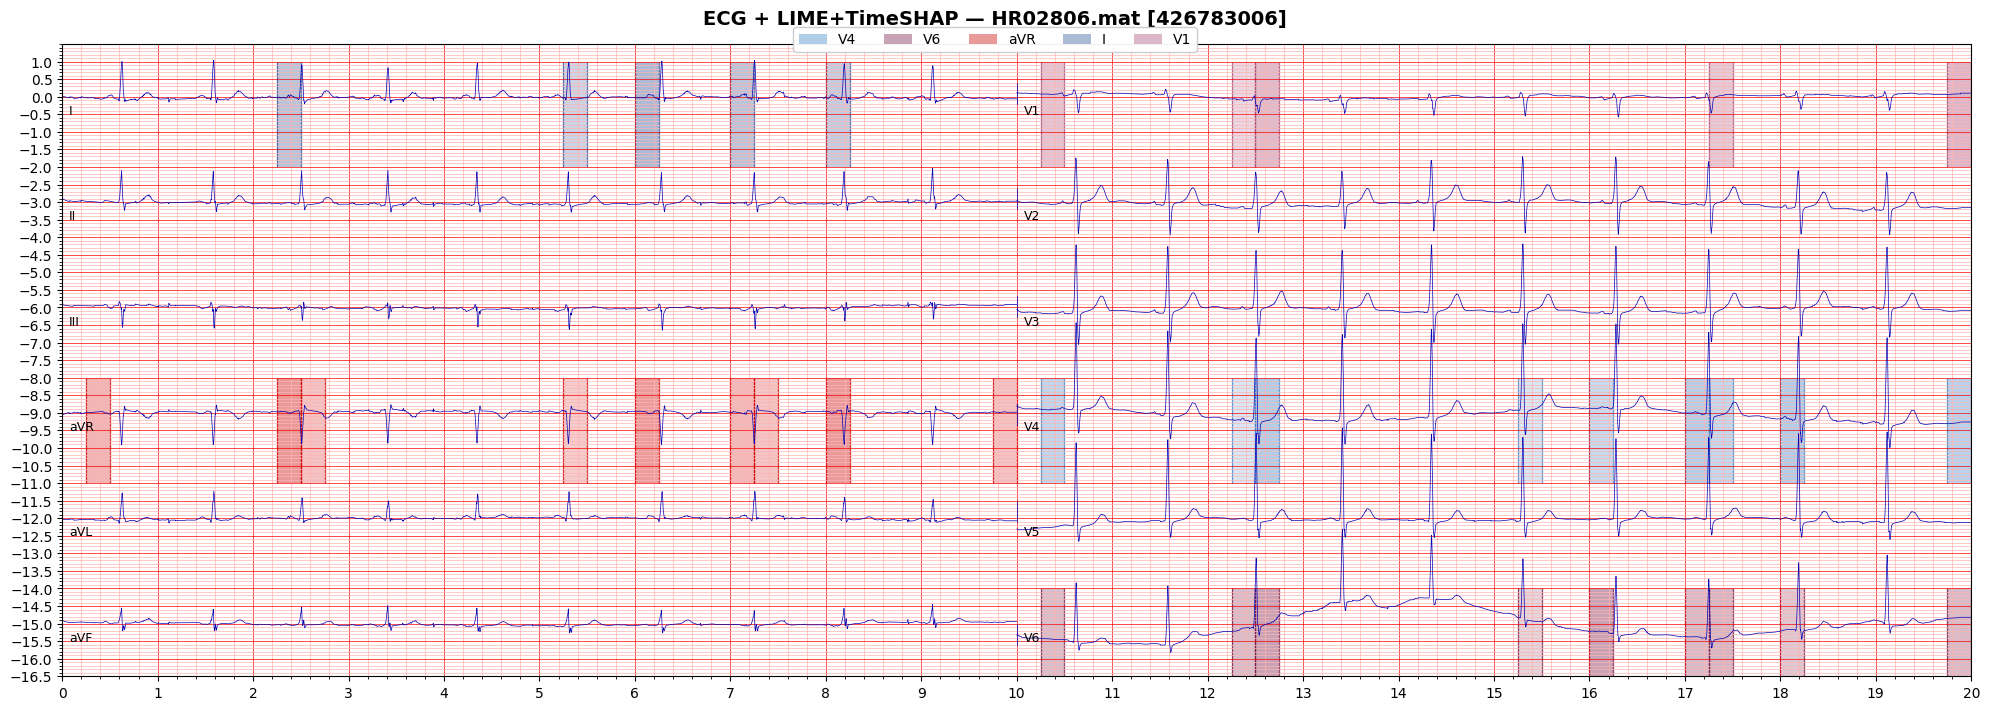

<Figure size 2000x600 with 0 Axes>

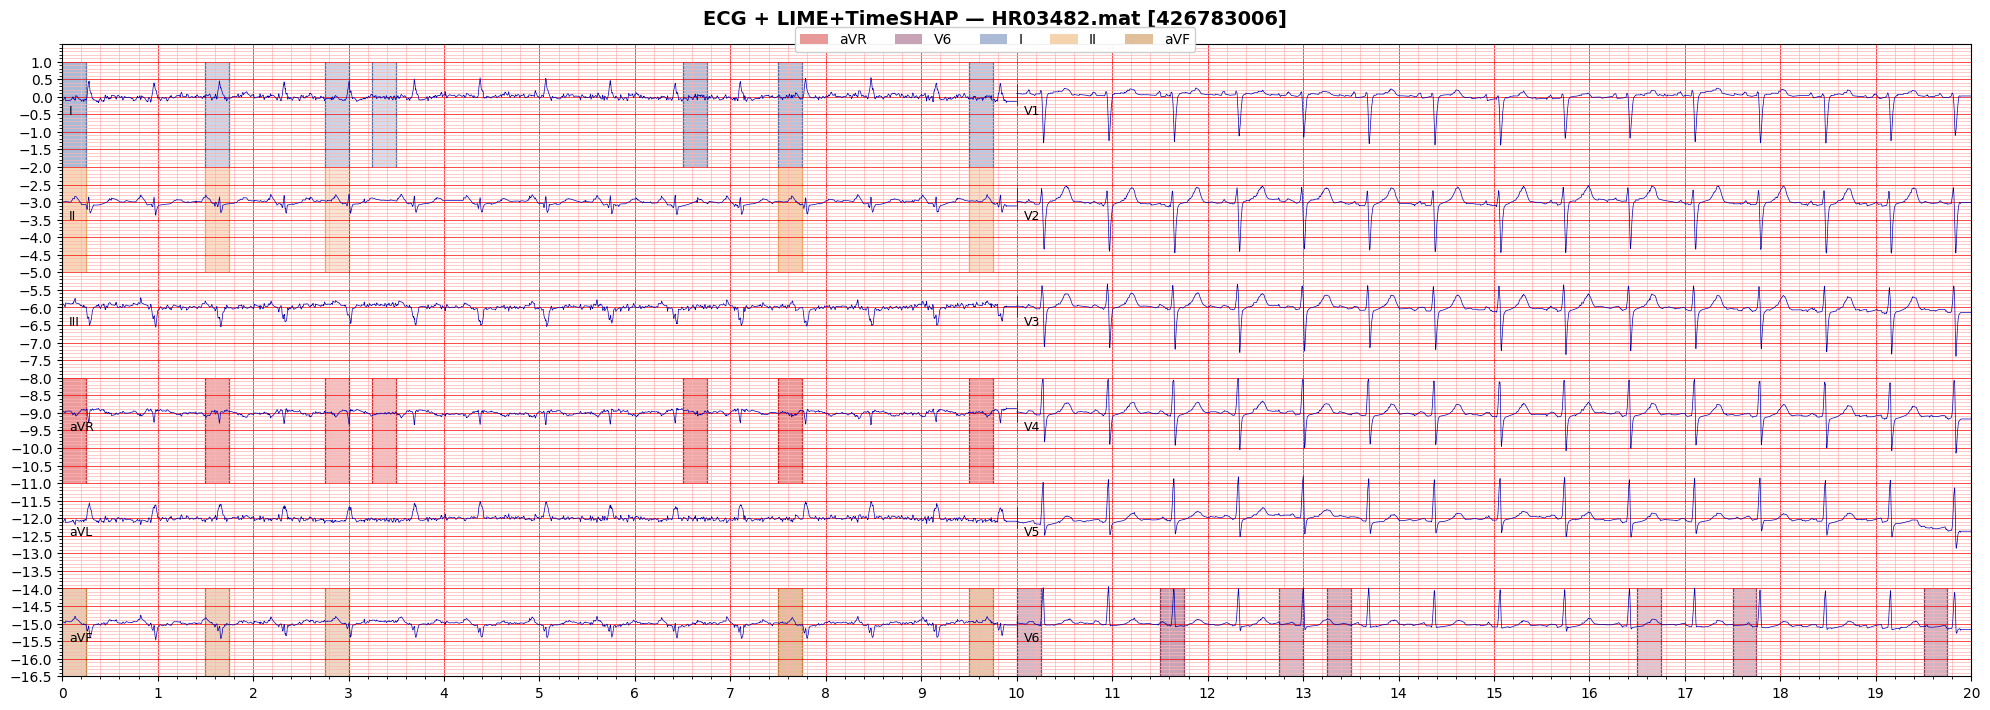

<Figure size 2000x600 with 0 Axes>

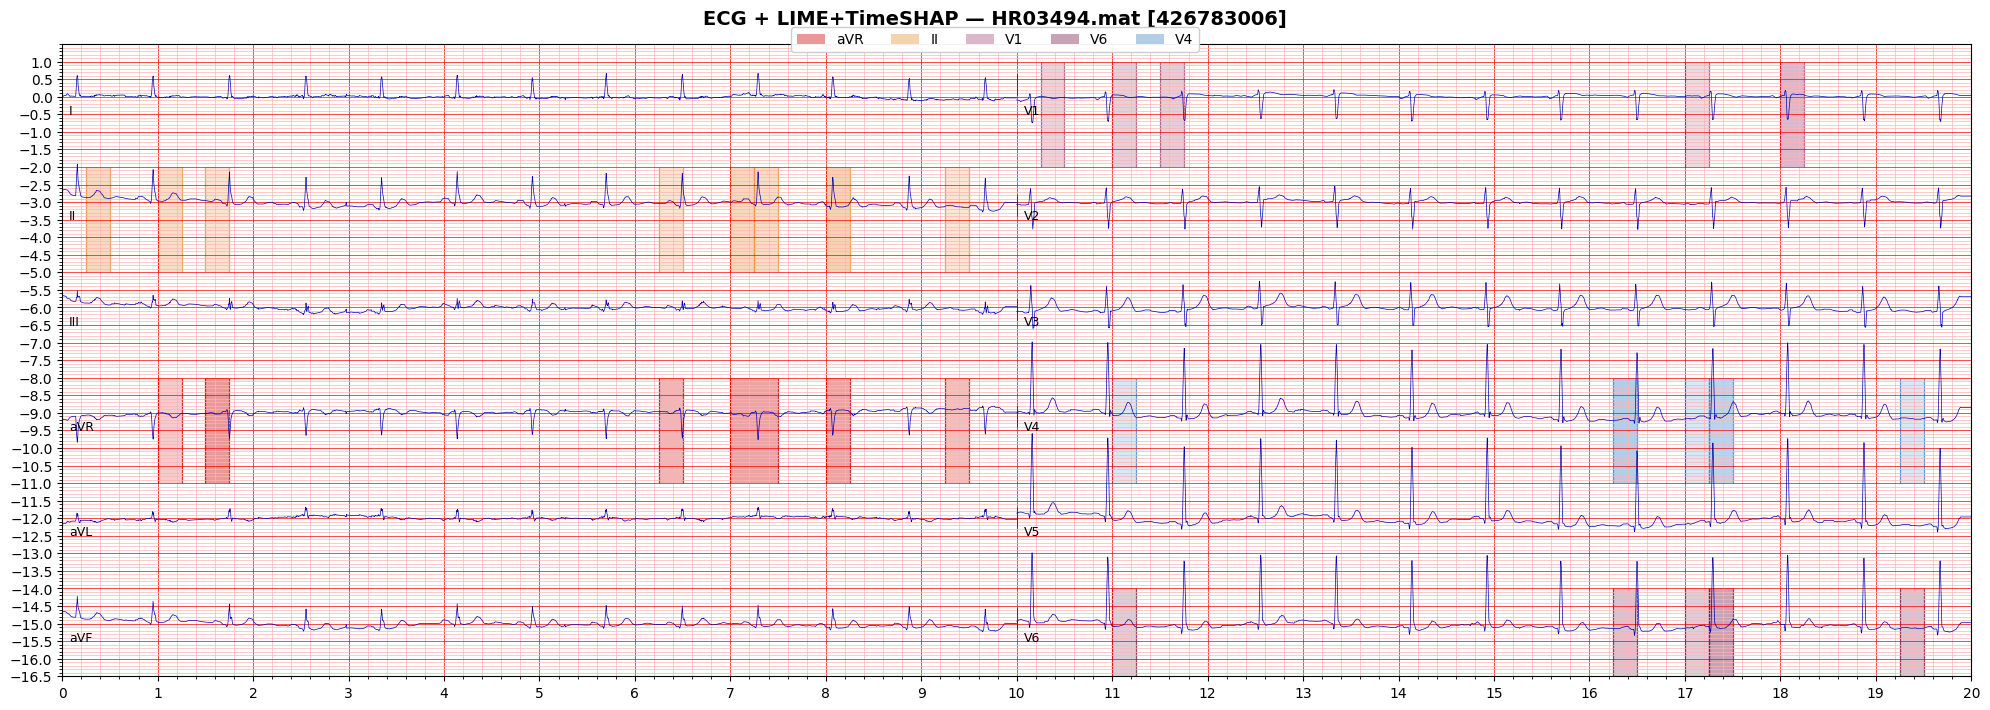

In [73]:
from ecgxai.payload import payload_from_lime_row, payload_from_timeshap_row
from ecgxai.fusion import fuse_lime_timeshap_payload
from ecgxai.plot import plot_from_payload

all_fused_payloads = {}

for cls in target_classes:
    L = df_lime_all[df_lime_all["group_class"].astype(str) == str(cls)].copy()
    T = df_ts_all[df_ts_all["group_class"].astype(str) == str(cls)].copy()

    if L.empty or T.empty:
        all_fused_payloads[str(cls)] = {}
        continue

    # common ids
    common = sorted(set(L["val_idx"].astype(int)) & set(T["val_idx"].astype(int)))
    fused_cls = {}

    for val_i in common:
        row_L = L.loc[L["val_idx"].astype(int) == val_i].iloc[0]
        row_T = T.loc[T["val_idx"].astype(int) == val_i].iloc[0]

        payload_L = payload_from_lime_row(row_L, label_for_title=row_L.get("group_class", str(cls)))
        payload_T = payload_from_timeshap_row(row_T, label_for_title=row_T.get("group_class", str(cls)))

        # optional per-class weights (same idea as your explainer.py)
        method_weights = (0.5, 0.5)
        if str(cls) == "426783006":  # sinus rhythm
            method_weights = (0.7, 0.3)

        payload_F = fuse_lime_timeshap_payload(
            payload_L, payload_T,
            agg="geomean",
            beta=1.0,
            tau=0.02,
            topk=5,
            method_weights=method_weights,
        )

        fused_cls[int(val_i)] = payload_F

        if cfg["plot"]:
            plot_from_payload(payload_F)

    all_fused_payloads[str(cls)] = fused_cls

# joblib.dump(all_fused_payloads, FUSED_PATH)
# print("Saved fused payloads:", FUSED_PATH)

## 7) Evaluate explanations

In [74]:
# --- 13) Evaluate all payloads ---
df_eval_all = evaluate_all_payloads(
    all_payloads=all_fused_payloads,
    method_label="LIME+TimeSHAP",
    model=model,
    class_names=class_names,
)

df_eval_all.to_csv(EVAL_CSV_PATH, index=False)
print("Saved:", EVAL_CSV_PATH)

df_eval_all

Saved: c:\UHull\ecg-xai\outputs\demo\df_eval_attauc_deletion.csv


,meta_code,class_name,sel_idx,mat_path,method,strict_attauc,lenient_attauc,precision_k,strict_p_at_k,lenient_p_at_k,deletion_auc,faithfulness_gain,n_tokens
0,164889003,atrial fibrillation,0,c:\UHull\ecg-xai\data\sample\A0003.mat,LIME+TimeSHAP,0.916400,0.694650,20,0.70,1.0,0.277588,-0.000403,300
1,164889003,atrial fibrillation,16,c:\UHull\ecg-xai\data\sample\A2643.mat,LIME+TimeSHAP,0.860373,0.689453,20,0.45,1.0,0.292567,0.023357,288
2,164889003,atrial fibrillation,19,c:\UHull\ecg-xai\data\sample\A2978.mat,LIME+TimeSHAP,0.865364,0.641847,20,0.35,1.0,0.232785,0.231309,324
3,426783006,sinus rhythm,79,c:\UHull\ecg-xai\data\sample\HR02806.mat,LIME+TimeSHAP,0.822000,1.000000,20,0.30,1.0,0.290672,0.009248,120
4,426783006,sinus rhythm,89,c:\UHull\ecg-xai\data\sample\HR03482.mat,LIME+TimeSHAP,0.856778,1.000000,20,0.45,1.0,0.290601,0.006554,180
5,426783006,sinus rhythm,90,c:\UHull\ecg-xai\data\sample\HR03494.mat,LIME+TimeSHAP,0.872781,1.000000,20,0.40,1.0,0.269049,0.015285,156


## 8) Stability to an extra heartbeat

We assess stability under a synthetic perturbation where one existing beat is duplicated and inserted at the **middle** of the recording.

For each target class:
- take up to `CFG.max_examples_per_class` examples (from the evaluation table),
- run the extra-beat augmentation + fused explainability,
- compute region-level agreement metrics (Spearman, Jaccard@K, etc.).

In [77]:
cfg

{'max_examples_per_class': 3, 'plot': True}

In [79]:
# --- Extra-beat stability experiment ---
MAX_PER_CLASS = cfg["max_examples_per_class"]
BASE_SEED = 1234

stability_rows = []

df_eval = df_eval_all.copy()
df_eval["meta_code"] = df_eval["meta_code"].astype(str)

for meta_code_str, df_cls in df_eval.groupby("meta_code", sort=False):
    class_name = str(TARGET_META[str(meta_code_str)]["name"])

    # Skip already-augmented mats (optional)
    df_cls = df_cls[~df_cls["mat_path"].str.contains(r"_extra_.*\.mat$", case=False, na=False)]

    if MAX_PER_CLASS is not None:
        df_cls = df_cls.head(MAX_PER_CLASS)

    print(f"\n=== Class {meta_code_str} ({class_name}) | n={len(df_cls)} ===")

    for _, row in df_cls.iterrows():
        mat_path = row["mat_path"]
        sel_idx  = int(row.get("sel_idx", 0))

        # deterministic per record
        seed = (int(BASE_SEED) ^ (zlib.crc32(mat_path.encode("utf-8")) & 0xFFFFFFFF)) & 0xFFFFFFFF
        print(f"  -> [{meta_code_str}] sel_idx={sel_idx} | seed={seed} | {mat_path}")

        try:
            metrics, *_ = run_extra_beat_stability_experiment(
                mat_path=mat_path,
                snomed_code=str(meta_code_str),
                model=model,
                class_names=class_names,
                augment_root=STAB_OUT_DIR,
                seed=seed,
            )

            extra = (metrics.get("extra") or {})
            stability_rows.append({
                "meta_code": str(meta_code_str),
                "class_name": class_name,
                "sel_idx": sel_idx,
                "mat_path": mat_path,
                "seed": seed,
                "augment_beat_index": metrics.get("augment_beat_index"),
                "augmented_file": metrics.get("augmented_file"),
                "extra_spearman": extra.get("spearman"),
                "extra_jaccard": extra.get("jaccard_topk"),
                "extra_rbo": extra.get("rbo"),
                "extra_wjacc": extra.get("weighted_jaccard"),
                "extra_k_eff": extra.get("k_eff"),
            })
        except Exception as e:
            stability_rows.append({
                "meta_code": str(meta_code_str),
                "class_name": class_name,
                "sel_idx": sel_idx,
                "mat_path": mat_path,
                "seed": seed,
                "error": repr(e),
            })
            print("failed:", e)

df_stability = pd.DataFrame(stability_rows)
df_stability.to_csv(STAB_CSV_PATH, index=False)
print("Saved:", STAB_CSV_PATH)

df_stability



=== Class 164889003 (atrial fibrillation) | n=3 ===
  -> [164889003] sel_idx=0 | seed=2374036356 | c:\UHull\ecg-xai\data\sample\A0003.mat
FUSED 164889003 | n=2 | win=0.5s mE=100 mF=100 topkE=5 | LIME=0m33s TS=0m27s | fused=2 | total=1m01s
Fused pipeline complete: 1 classes in 1m01s
  -> [164889003] sel_idx=16 | seed=937728981 | c:\UHull\ecg-xai\data\sample\A2643.mat
FUSED 164889003 | n=2 | win=0.5s mE=100 mF=100 topkE=5 | LIME=0m38s TS=0m25s | fused=2 | total=1m04s
Fused pipeline complete: 1 classes in 1m04s
  -> [164889003] sel_idx=19 | seed=820553859 | c:\UHull\ecg-xai\data\sample\A2978.mat
FUSED 164889003 | n=2 | win=0.5s mE=100 mF=100 topkE=5 | LIME=0m33s TS=0m25s | fused=2 | total=0m58s
Fused pipeline complete: 1 classes in 0m58s

=== Class 426783006 (sinus rhythm) | n=3 ===
  -> [426783006] sel_idx=79 | seed=4276192703 | c:\UHull\ecg-xai\data\sample\HR02806.mat
FUSED 426783006 | n=2 | win=0.25s mE=100 mF=100 topkE=5 | LIME=0m32s TS=0m24s | fused=2 | total=0m57s
Fused pipeline co

,meta_code,class_name,sel_idx,mat_path,seed,augment_beat_index,augmented_file,extra_spearman,extra_jaccard,extra_rbo,extra_wjacc,extra_k_eff
0,164889003,atrial fibrillation,0,c:\UHull\ecg-xai\data\sample\A0003.mat,2374036356,12,c:\UHull\ecg-xai\outputs\extra_beat_aug\A0003\...,0.917329,0.481481,0.171986,0.907574,20.0
1,164889003,atrial fibrillation,16,c:\UHull\ecg-xai\data\sample\A2643.mat,937728981,12,c:\UHull\ecg-xai\outputs\extra_beat_aug\A2643\...,0.928149,0.523810,0.486000,0.951839,16.0
2,164889003,atrial fibrillation,19,c:\UHull\ecg-xai\data\sample\A2978.mat,820553859,13,c:\UHull\ecg-xai\outputs\extra_beat_aug\A2978\...,0.896839,0.428571,0.199849,0.941550,20.0
3,426783006,sinus rhythm,79,c:\UHull\ecg-xai\data\sample\HR02806.mat,4276192703,8,c:\UHull\ecg-xai\outputs\extra_beat_aug\HR0280...,0.989932,1.000000,0.541185,0.982772,11.0
4,426783006,sinus rhythm,89,c:\UHull\ecg-xai\data\sample\HR03482.mat,3963145208,2,c:\UHull\ecg-xai\outputs\extra_beat_aug\HR0348...,0.911378,0.240000,0.419646,0.943769,18.0
5,426783006,sinus rhythm,90,c:\UHull\ecg-xai\data\sample\HR03494.mat,2820992509,3,c:\UHull\ecg-xai\outputs\extra_beat_aug\HR0349...,0.886891,1.000000,0.068933,0.969588,10.0


## 9) Per-class summary (mean/std + counts)

In [80]:
metric_cols = ["extra_spearman", "extra_jaccard", "extra_rbo", "extra_wjacc", "extra_k_eff"]

# rows that succeeded (no error column or error is null)
ok = df_stability.copy()
if "error" in ok.columns:
    ok = ok[ok["error"].isna()]

summary = (ok.groupby(["meta_code", "class_name"])
            .agg(
                n=("mat_path", "count"),
                spearman_mean=("extra_spearman", "mean"),
                spearman_std=("extra_spearman", "std"),
                jaccard_mean=("extra_jaccard", "mean"),
                jaccard_std=("extra_jaccard", "std"),
                rbo_mean=("extra_rbo", "mean"),
                wjacc_mean=("extra_wjacc", "mean"),
                k_eff_mean=("extra_k_eff", "mean"),
            )
            .reset_index()
            .sort_values(["meta_code"]))

show = summary[["meta_code","class_name","n","spearman_mean","jaccard_mean","k_eff_mean"]]
show

,meta_code,class_name,n,spearman_mean,jaccard_mean,k_eff_mean
0,164889003,atrial fibrillation,3,0.914106,0.477954,18.666667
1,426783006,sinus rhythm,3,0.929401,0.746667,13.000000
